<a href="https://colab.research.google.com/github/yanada1307/14IF_Multi-label-Emotion-Classification/blob/main/Proyek_PBA_Sprinkle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PROYEK PBA KELOMPOK SPRINKLE**
**Pemrosesan Bahasa Alami**

**Kamis, 18 November 2021**


1.   11S18015 - Yanada Sari Br Situmorang
2.   11S18002 - Putri Era Waty Bakara
3.   11S18010 - N. Priskila Napitupulu
4.   11S18012 - Suryani Vebhitry Siahaan
5.   11S18038 - Grace Winda N Naibaho
6.   11S18063 - Elyta Junetta Siregar





---

In [1]:
!pip3 install datasets transformers -q

     |████████████████████████████████| 290 kB 6.9 MB/s 
     |████████████████████████████████| 3.1 MB 41.6 MB/s 
     |████████████████████████████████| 243 kB 67.3 MB/s 
     |████████████████████████████████| 1.1 MB 64.1 MB/s 
     |████████████████████████████████| 132 kB 56.6 MB/s 
     |████████████████████████████████| 59 kB 6.1 MB/s 
     |████████████████████████████████| 3.3 MB 41.9 MB/s 
     |████████████████████████████████| 596 kB 36.7 MB/s 
     |████████████████████████████████| 895 kB 61.3 MB/s 
     |████████████████████████████████| 192 kB 56.2 MB/s 
     |████████████████████████████████| 160 kB 52.9 MB/s 
     |████████████████████████████████| 271 kB 53.0 MB/s 


In [2]:
!pip install tez

In [3]:
from datasets import load_dataset

import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from torch.utils.data import DataLoader

import os
import random
import tez
import torch
import torch.nn as nn
import transformers
from sklearn import metrics, model_selection, preprocessing
from transformers import AdamW, get_linear_schedule_with_warmup

**Load dataset go_emotions dan split menjadi train, validation, dan test**

In [4]:
go_emotions = load_dataset("go_emotions")

data = go_emotions.data

Downloading:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

No config specified, defaulting to: go_emotions/simplified


Downloading:   0%|          | 0.00/1.61M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/203k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/201k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
train = go_emotions.data["train"].to_pandas()
valid = go_emotions.data["validation"].to_pandas()
test = go_emotions.data["test"].to_pandas()

In [6]:
print(train.shape, valid.shape, test.shape)

(43410, 3) (5426, 3) (5427, 3)


In [7]:
train.head() 

,text,labels,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj


**Convert dataset menjadi representasi one-hot**

In [8]:
mapping = {
    0:"admiration",
    1:"amusement",
    2:"anger",
    3:"annoyance",
    4:"approval",
    5:"caring",
    6:"confusion",
    7:"curiosity",
    8:"desire",
    9:"disappointment",
    10:"disapproval",
    11:"disgust",
    12:"embarrassment",
    13:"excitement",
    14:"fear",
    15:"gratitude",
    16:"grief",
    17:"joy",
    18:"love",
    19:"nervousness",
    20:"optimism",
    21:"pride",
    22:"realization",
    23:"relief",
    24:"remorse",
    25:"sadness",
    26:"surprise",
    27:"neutral",
}

n_labels = len(mapping)

In [9]:
def one_hot_labels(df):
    dict_labels= []
    for i in tqdm(range(len(df))):
        d = [0]*n_labels
        labels = df.iloc[i]["labels"]
        
        for label in labels:
            d[label] = 1
        dict_labels.append(d)
        
    return pd.DataFrame(dict_labels)

In [10]:
train_oh_labels = one_hot_labels(train)
valid_oh_labels = one_hot_labels(valid)
test_oh_labels = one_hot_labels(test)

  0%|          | 0/43410 [00:00<?, ?it/s]

  0%|          | 0/5426 [00:00<?, ?it/s]

  0%|          | 0/5427 [00:00<?, ?it/s]

In [11]:
train_oh_labels.shape

(43410, 28)

In [12]:
train = pd.concat([train, train_oh_labels], axis=1)
valid = pd.concat([valid, valid_oh_labels], axis=1)
test = pd.concat([test, test_oh_labels], axis=1)

**Cek kembali datanya**

In [13]:
print(train.shape, valid.shape, test.shape)

(43410, 31) (5426, 31) (5427, 31)


In [14]:
train.head()

,text,labels,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,My favourite food is anything I didn't have to...,[27],eebbqej,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,[14],ed7ypvh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Dirty Southern Wankers,[3],ed0bdzj,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


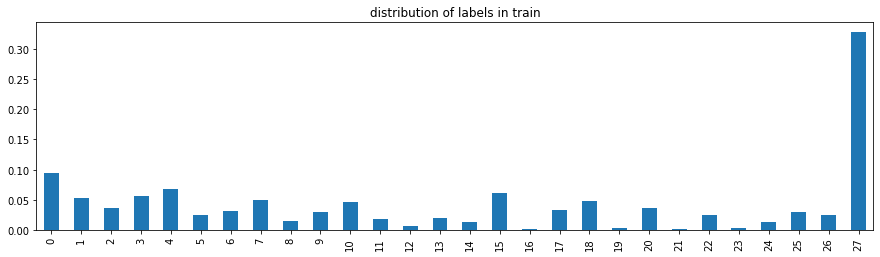

In [15]:
fig = plt.figure(figsize=(15, 13))

ax1 = plt.subplot(3, 1, 1)
train[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax1, title="distribution of labels in train")

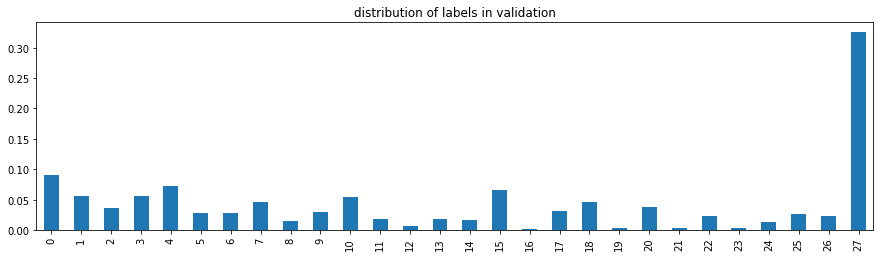

In [16]:
fig = plt.figure(figsize=(15, 13))

ax2 = plt.subplot(3, 1, 2)
valid[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax2, title="distribution of labels in validation")

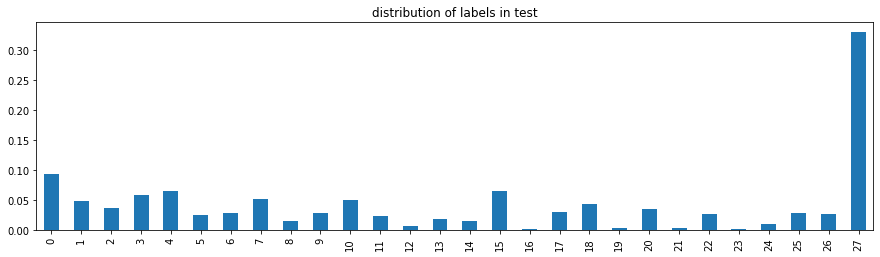

In [17]:
fig = plt.figure(figsize=(15, 13))

ax3 = plt.subplot(3, 1, 3)
test[range(n_labels)].mean(axis=0).plot(kind="bar", ax=ax3, title="distribution of labels in test")

In [18]:
def inspect_data(label, n=5):
    samples = train[train[label] == 1].sample(5)
    sentiment = mapping[label]
    
    print(f"examples from {sentiment}")
    print()
    for text in samples["text"]:
        print(text)
        print("---")

**Beberapa ulasan dari emotions**

In [19]:
inspect_data(0)

examples from admiration

Yeah I suppose lol, but either way yours is the best one I've seen so far 
---
< video does a good job explaining push/pull.
---
Seriously. [NAME] is a hero. I heard he was a volunteer firefighter during 9/11.
---
Damn perfect 👌
---
Great trade for us but we're losing some forward depth in [NAME]. Tbh though I would be willing to take the risk.
---


In [20]:
inspect_data(1)

examples from amusement

🤣🤣🤣🤣 I’m sorry for your misfortune but it’s still funny too.
---
What? lol no. I feel bad they have to, but there are legit people who enjoy wearing it to show devotion.
---
I went to McDonald’s and ate. I guess I also enjoy psychological manipulation
---
We don't lmao. Anything with humans will have the same problems.
---
Hello! [NAME] is beautiful but I’ve only been once. I never had the whisky so I can’t even argue haha.
---


In [21]:
inspect_data(2)

examples from anger

Fuck the White House, fuck McDonald’s and fuck this post.
---
Screw them. We do what we have to do to get our kids to eat.
---
Your comment is completely irrelevant and you're trolling me in order for you to cry and whine about Detroit. Get out of here.
---
I'm leaving to go get some more motherfucking jokes MOM [NAME]
---
Let them argue. We've never done anything remotely as bad as MOST OF THE WORLD does routinely.
---


In [22]:
inspect_data(3)

examples from annoyance

Seems like every season she is less hot. Too bad
---
Oh don’t get me started about halo, the glory days
---
Excuse me who the hell is that?
---
happened to me last week too with mango, the pods were half empty and wet. handling them made my finger tips hurt after a while
---
You're going to be pissed.
---


In [23]:
inspect_data(4)

examples from approval

The idea that fb might be slowly killing mlms out there gives me a glimmer of satisfaction...
---
What a sheltered life you have lived.
---
Well duh, he’s a scientist. So he’s probably smarter than the average anti vaxxer
---
This live meet the queens is awkward AF, I’d rather them produce this and make us watch nicely edited stuff.
---
I don’t set an alarm I naturally wake around 4am. Love my mornings.
---


In [24]:
inspect_data(5)

examples from caring

You've been muted. Usually awarded for extreme toxicity, don't worry though its temporary.
---
I'm sorry for your loss. Also send a Mass card.
---
Like the op said, [NAME] is more of a giver, so I think [NAME] would be happy as long as [NAME] would be happy
---
Kids, if you're on a dating site that advertises itself as "dating site for millionaires" you're gonna have a bad time
---
Peace be with you
---


**Menetukan kumpulan data PyTorch**

In [25]:
class GoEmotionDataset():
    def __init__(self, texts, targets):
        self.texts = texts
        self.targets = targets
        self.tokenizer = transformers.SqueezeBertTokenizer.from_pretrained(
            "squeezebert/squeezebert-uncased", do_lower_case=True
        )
        self.max_len = 35
 
    def __len__(self):
        return len(self.texts)

    
    def __getitem__(self, index):
        target = self.targets[index]
        text = self.texts[index]

        inputs = self.tokenizer.encode_plus(text,
                                            None,
                                            add_special_tokens=True,
                                            max_length=self.max_len,
                                            padding="max_length",
                                            truncation=True)
        
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "targets": torch.tensor(self.targets[index], dtype=torch.long),
        }

**Mendefinisikan Tez** 

In [26]:
class EmotionClassifier(tez.Model):
    def __init__(self, num_train_steps, num_classes):
        super().__init__()
        self.bert = transformers.SqueezeBertModel.from_pretrained("squeezebert/squeezebert-uncased")
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768, num_classes)
        self.num_train_steps = num_train_steps
        self.step_scheduler_after = "batch"

In [27]:
    def fetch_optimizer(self):
        param_optimizer = list(self.named_parameters())
        no_decay = ["bias", "LayerNorm.bias"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        opt = AdamW(optimizer_parameters, lr=3e-5)
        return opt

In [28]:
    def fetch_scheduler(self):
        sch = get_linear_schedule_with_warmup(
            self.optimizer, num_warmup_steps=0, num_training_steps=self.num_train_steps
        )
        return sch
    
    def loss(self, outputs, targets):
        if targets is None:
            return None
        return nn.BCEWithLogitsLoss()(outputs, targets.float())

In [29]:
def monitor_metrics(self, outputs, targets):
        if targets is None:
            return {}
        
        outputs = torch.sigmoid(outputs)
        outputs = outputs.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        
        fpr_micro, tpr_micro, _ = metrics.roc_curve(targets.ravel(), outputs.ravel())
        auc_micro = metrics.auc(fpr_micro, tpr_micro)
        return {"auc": auc_micro}